In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPooling2D,Add,BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,SeparableConv2D,ReLU,GlobalAvgPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.metrics import Recall, Precision

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import seaborn as sns
import time
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from preprocess_blur import preprocess
from Gradcam import GradCAM
from display_random_image import display_image
from display_bar_chart import display_bar_chart

In [2]:
image_size = 380

labels = ['Level_0','Level_1','Level_2','level_3','Level_4']

In [3]:
def create_data(paths):
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):
            image_read = cv.imread(os.path.join(dir,image))
            image_read = cv.cvtColor(image_read,cv.COLOR_BGR2RGB)
            image_resized = preprocess(image_read,sigmaX=10,IMG_SIZE=380)
            image_resized = cv.resize(image_resized,(image_size,image_size))
            image_resized= preprocess_input(image_resized)
            images.append([image_resized,class_num])
            
    return np.array(images)

In [4]:
val = create_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Val/')

In [5]:
train = create_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Merged/')

In [6]:
#load train images and labels in X_train and y_train

X_train = []
y_train = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = np.expand_dims(y_train, axis=1)

print(X_train.shape)
print(y_train.shape)

(31209, 380, 380, 3)
(31209, 1)


In [7]:
X_val = []
y_val = []

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)
    
X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = np.expand_dims(y_val, axis=1)

print(X_val.shape)
print(y_val.shape)

(5125, 380, 380, 3)
(5125, 1)


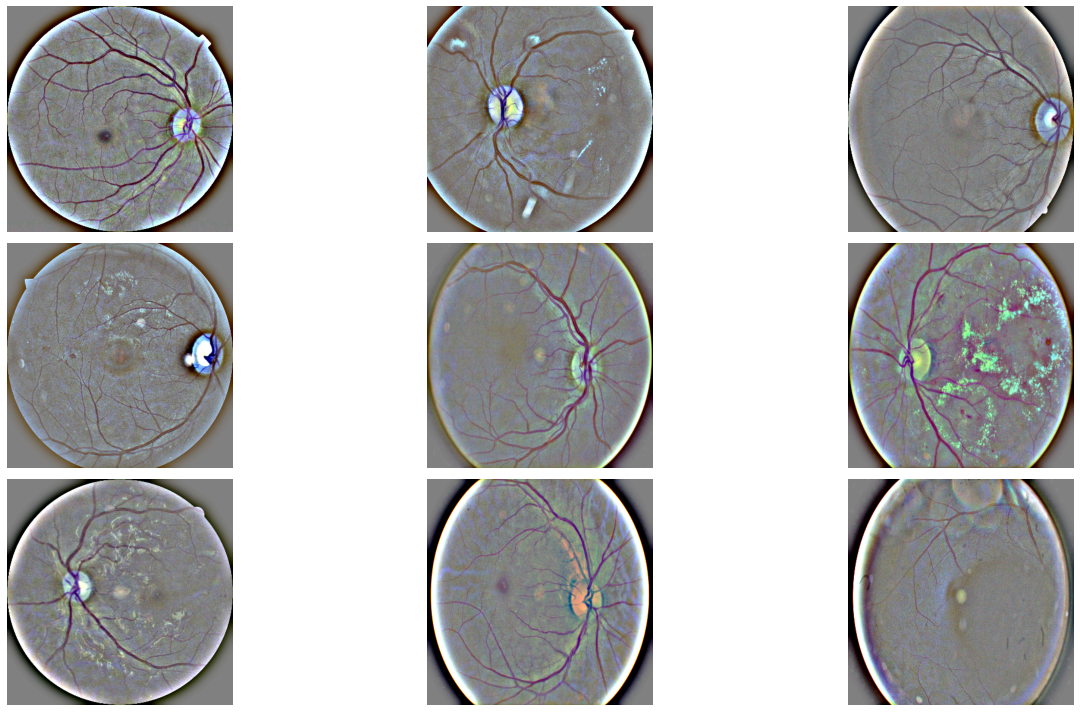

In [8]:
display_image(X_train)

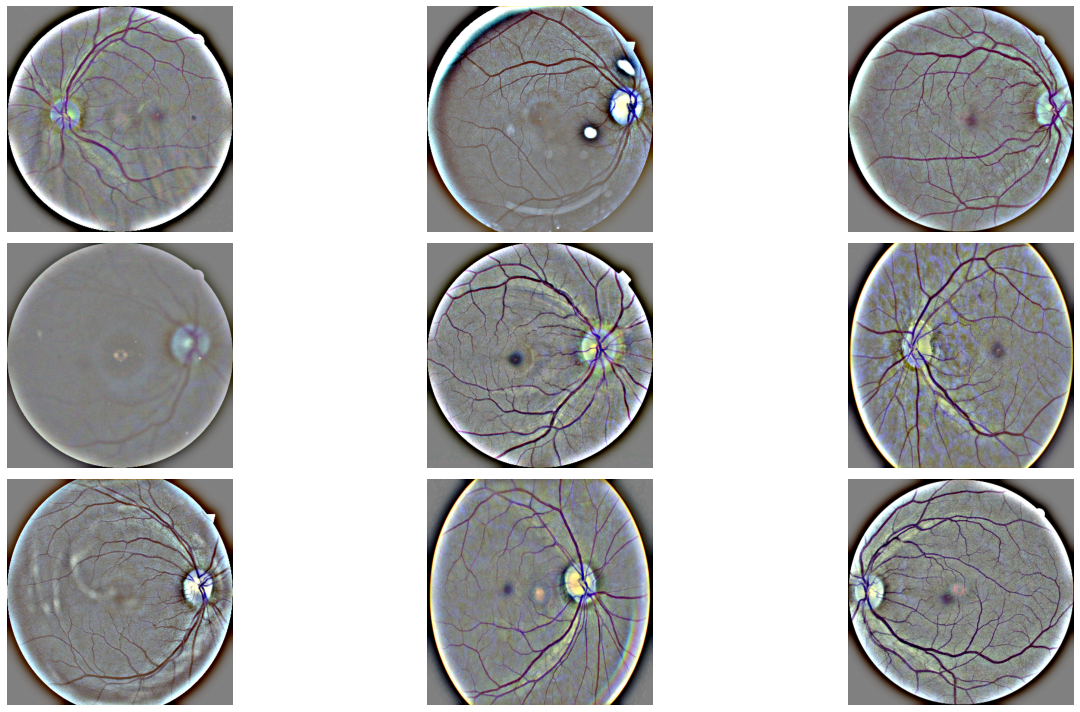

In [9]:
display_image(X_val)

Number of Level_0 images =  6685
Number of Level_1 images =  6180
Number of Level_2 images =  6552
Number of Level_3 images =  5912
Number of Level_4 images =  5880


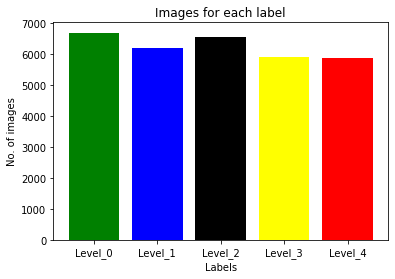

In [10]:
display_bar_chart(y_train)

In [11]:
input_shape = [380,380]

base_model = EfficientNetB4 (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.2)(x)
    
outputs = Dense(5, activation="softmax")(x)

# Compile
model = Model(base_model.input, outputs, name="EfficientNet")
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [12]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [13]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = ModelCheckpoint('EfficientNetb4_blur_1.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

In [14]:
batch_size = 8

r = model.fit(X_train,y_train, validation_data=(X_val,y_val), 
                        batch_size=batch_size, epochs= 150, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/150
3902/3902 [==============================] - 1466s 376ms/step - loss: 1.5569 - accuracy: 0.3981 - val_loss: 0.9449 - val_accuracy: 0.7899
Epoch 2/150
3902/3902 [==============================] - 1472s 377ms/step - loss: 1.1781 - accuracy: 0.5074 - val_loss: 0.8431 - val_accuracy: 0.7438
Epoch 3/150
3902/3902 [==============================] - 1468s 376ms/step - loss: 1.1028 - accuracy: 0.5401 - val_loss: 1.1378 - val_accuracy: 0.5442
Epoch 4/150
3902/3902 [==============================] - 1464s 375ms/step - loss: 1.0549 - accuracy: 0.5701 - val_loss: 1.6113 - val_accuracy: 0.2648
Epoch 5/150
3902/3902 [==============================] - 1464s 375ms/step - loss: 1.0057 - accuracy: 0.6113 - val_loss: 0.7763 - val_accuracy: 0.7690
Epoch 6/150
3902/3902 [==============================] - 1465s 375ms/step - loss: 0.9677 - accuracy: 0.6340 - val_loss: 0.7905 - val_accuracy: 0.7762
Epoch 7/150
3902/3902 [==============================] - 1465s 375ms/step - loss: 0.9303 - accuracy:

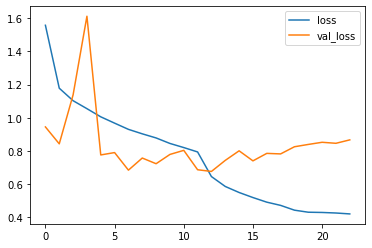

In [15]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

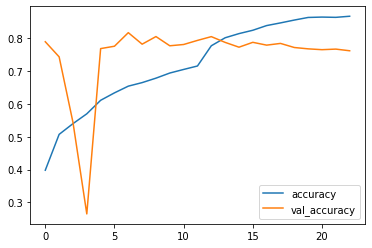

In [16]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [10]:
model2 = tf.keras.models.load_model('EfficientNetb4_blur_1.h5')

In [18]:
P= model2.predict(X_val, steps=len(X_val)).argmax(axis=1)

([<matplotlib.axis.YTick at 0x1638691e1c8>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

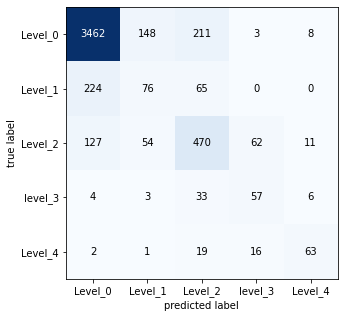

In [19]:
matrix = confusion_matrix (y_val, P)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

In [11]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)

stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = ModelCheckpoint('EfficientNetb4_blur_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

In [12]:
model2.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [13]:
model2.compile(optimizer=Adam(lr=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

batch_size = 4

r = model2.fit(X_train,y_train, validation_data=(X_val,y_val), 
                        batch_size=batch_size, epochs= 50, 
                        callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/50
7803/7803 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.7706   E - ETA: 1:04 - loss: - ETA: 1:01 - loss: 0.6 - ETA: 58s - loss: 0.6655 - accurac - ETA: 56s - loss: 0.6655 - a - ETA: 53s - 
Epoch 00001: val_loss improved from inf to 0.71743, saving model to EfficientNetb4_blur_2.h5
7803/7803 [==============================] - 1696s 217ms/step - loss: 0.6654 - accuracy: 0.7706 - val_loss: 0.7174 - val_accuracy: 0.7953
Epoch 2/50
7803/7803 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7742 - ETA - ETA: 21s - loss: 0.6537 - ac
Epoch 00002: val_loss improved from 0.71743 to 0.71051, saving model to EfficientNetb4_blur_2.h5
7803/7803 [==============================] - 1699s 218ms/step - loss: 0.6532 - accuracy: 0.7742 - val_loss: 0.7105 - val_accuracy: 0.7959
Epoch 3/50
7803/7803 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.7787   ETA  - ETA: 56s - loss: 0.637 - ETA: 51s - loss: 0.
Epoch 00003: val_loss

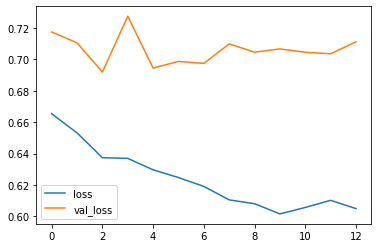

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

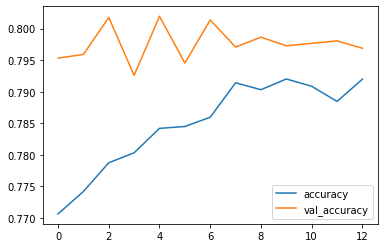

In [15]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [16]:
final_model = tf.keras.models.load_model('EfficientNetb4_blur_2.h5')

In [17]:
P2 = final_model.predict(X_val, batch_size=4).argmax(axis=1)

([<matplotlib.axis.YTick at 0x1ec940e74c8>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

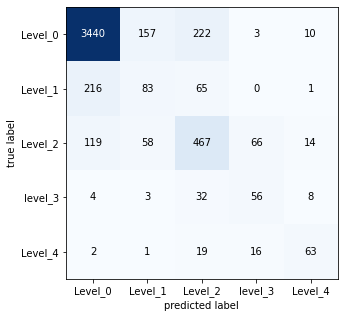

In [18]:
matrix = confusion_matrix (y_val, P2)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def f_score(y,P,level):
    
    print(f'Level_{level}')
    print('Weighted Precision: {:.2f}'.format(precision_score(y, P, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y, P, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y, P, average='weighted')))

In [55]:
def f_score_macro(y,P,level):
    
    print(f'Level_{level}')
    print('Macro Precision: {:.2f}'.format(precision_score(y, P, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y, P, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y, P, average='macro')))

In [62]:
def accuracy (y,P,level):
    
    print(f'Level_{level}')
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y, P)))

In [36]:
f_score(y_val==0,P2==0, 0)

Level_0
Weighted Precision: 0.86
Weighted Recall: 0.86
Weighted F1-score: 0.86


In [37]:
f_score(y_val==1,P2==1, 1)

Level_1
Weighted Precision: 0.89
Weighted Recall: 0.90
Weighted F1-score: 0.90


In [38]:
f_score(y_val==2,P2==2, 2)

Level_2
Weighted Precision: 0.89
Weighted Recall: 0.88
Weighted F1-score: 0.89


In [39]:
f_score(y_val==3,P2==3, 3)

Level_3
Weighted Precision: 0.98
Weighted Recall: 0.97
Weighted F1-score: 0.98


In [40]:
f_score(y_val==4,P2==4, 4)

Level_4
Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99


In [42]:
f_score(y_val,P2, 1234)

Level_1234
Weighted Precision: 0.80
Weighted Recall: 0.80
Weighted F1-score: 0.80


In [43]:
test = create_data('D:/Kaggle datasets/Thesis_Diabetic/Diabetic_Retinopathy/Test/')

In [44]:
#load test images and labels in X_test and y_test

X_test = []
y_test = []

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = np.expand_dims(y_test, axis=1)

print(X_test.shape)
print(y_test.shape)

(53576, 380, 380, 3)
(53576, 1)


### Model_2 results and confusion matrix

Number of Level_0 images =  39533
Number of Level_1 images =  3762
Number of Level_2 images =  7861
Number of Level_3 images =  1214
Number of Level_4 images =  1206


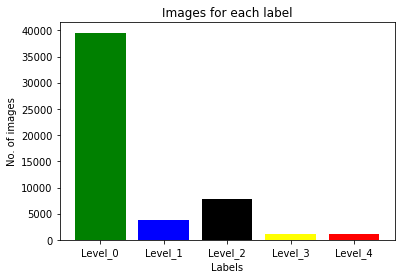

In [45]:
display_bar_chart(y_test)

In [46]:
P3 = final_model.predict(X_test, batch_size=4).argmax(axis=1)

Number of Level_0 images =  39362
Number of Level_1 images =  3094
Number of Level_2 images =  8153
Number of Level_3 images =  1720
Number of Level_4 images =  1247


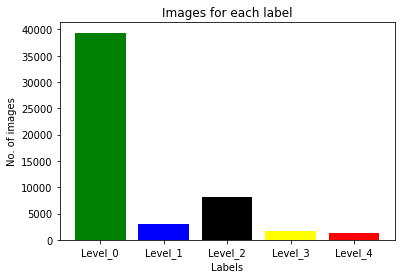

In [47]:
display_bar_chart(P3)

([<matplotlib.axis.YTick at 0x1ec99908408>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

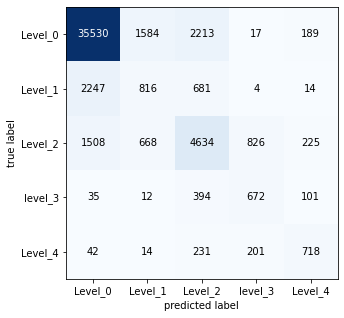

In [48]:
matrix = confusion_matrix (y_test, P3)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

### F_score Weighted Model_2

In [49]:
f_score(y_test==0,P3==0, 0)

Level_0
Weighted Precision: 0.85
Weighted Recall: 0.85
Weighted F1-score: 0.85


In [50]:
f_score(y_test==1,P3==1, 1)

Level_1
Weighted Precision: 0.89
Weighted Recall: 0.90
Weighted F1-score: 0.90


In [51]:
f_score(y_test==2,P3==2, 2)

Level_2
Weighted Precision: 0.88
Weighted Recall: 0.87
Weighted F1-score: 0.88


In [52]:
f_score(y_test==3,P3==3, 3)

Level_3
Weighted Precision: 0.98
Weighted Recall: 0.97
Weighted F1-score: 0.97


In [53]:
f_score(y_test==4,P3==4, 4)

Level_4
Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98


In [54]:
f_score(y_test,P3, 1234)

Level_1234
Weighted Precision: 0.79
Weighted Recall: 0.79
Weighted F1-score: 0.79


### F_score Macro Model_2

In [56]:
f_score_macro(y_test==0,P3==0, 0)

Level_0
Macro Precision: 0.81
Macro Recall: 0.81
Macro F1-score: 0.81



In [57]:
f_score_macro(y_test==1,P3==1, 1)

Level_1
Macro Precision: 0.60
Macro Recall: 0.59
Macro F1-score: 0.59



In [58]:
f_score_macro(y_test==2,P3==2, 2)

Level_2
Macro Precision: 0.75
Macro Recall: 0.76
Macro F1-score: 0.75



In [59]:
f_score_macro(y_test==3,P3==3, 3)

Level_3
Macro Precision: 0.69
Macro Recall: 0.77
Macro F1-score: 0.72



In [60]:
f_score_macro(y_test==4,P3==4, 4)

Level_4
Macro Precision: 0.78
Macro Recall: 0.79
Macro F1-score: 0.79



In [61]:
f_score_macro(y_test,P3, 1234)

Level_1234
Macro Precision: 0.54
Macro Recall: 0.57
Macro F1-score: 0.55



### Accuracy_Model_2

In [63]:
accuracy(y_test==0,P3==0,0)

Level_0

Accuracy: 0.85



In [64]:
accuracy(y_test==1,P3==1,1)

Level_1

Accuracy: 0.90



In [65]:
accuracy(y_test==2,P3==2,2)

Level_2

Accuracy: 0.87



In [66]:
accuracy(y_test==3,P3==3,3)

Level_3

Accuracy: 0.97



In [67]:
accuracy(y_test==4,P3==4,4)

Level_4

Accuracy: 0.98



In [68]:
accuracy(y_test,P3,1234)

Level_1234

Accuracy: 0.79



### Model_1

In [69]:
P4 = model2.predict(X_test, batch_size=4).argmax(axis=1)

Number of Level_0 images =  39533
Number of Level_1 images =  3762
Number of Level_2 images =  7861
Number of Level_3 images =  1214
Number of Level_4 images =  1206


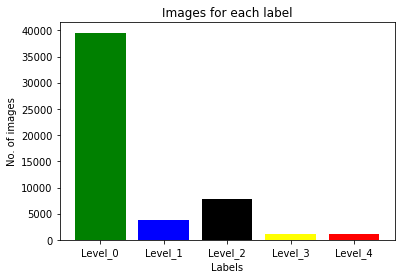

In [70]:
display_bar_chart(y_test)

Number of Level_0 images =  38783
Number of Level_1 images =  3615
Number of Level_2 images =  8314
Number of Level_3 images =  1596
Number of Level_4 images =  1268


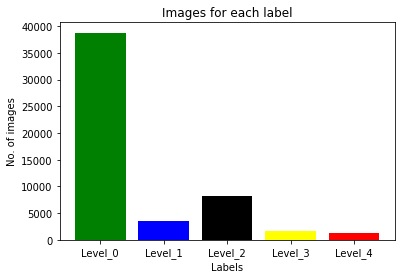

In [71]:
display_bar_chart(P4)

### Accuracy Model_1

In [72]:
accuracy(y_test==0,P4==0,0)
accuracy(y_test==1,P4==1,1)
accuracy(y_test==2,P4==2,2)
accuracy(y_test==3,P4==3,3)
accuracy(y_test==4,P4==4,4)
accuracy(y_test,P4,1234)

Level_0

Accuracy: 0.85

Level_1

Accuracy: 0.90

Level_2

Accuracy: 0.87

Level_3

Accuracy: 0.97

Level_4

Accuracy: 0.98

Level_1234

Accuracy: 0.78



### F_score Model_1

In [74]:
f_score_macro(y_test==0,P4==0,0)
f_score_macro(y_test==1,P4==1,1)
f_score_macro(y_test==2,P4==2,2)
f_score_macro(y_test==3,P4==3,3)
f_score_macro(y_test==4,P4==4,4)
f_score_macro(y_test,P4,1234)

Level_0
Macro Precision: 0.80
Macro Recall: 0.81
Macro F1-score: 0.81

Level_1
Macro Precision: 0.59
Macro Recall: 0.59
Macro F1-score: 0.59

Level_2
Macro Precision: 0.75
Macro Recall: 0.76
Macro F1-score: 0.75

Level_3
Macro Precision: 0.69
Macro Recall: 0.75
Macro F1-score: 0.72

Level_4
Macro Precision: 0.78
Macro Recall: 0.79
Macro F1-score: 0.79

Level_1234
Macro Precision: 0.53
Macro Recall: 0.57
Macro F1-score: 0.55



### F_score Weighted Model_1

In [75]:
f_score(y_test==0,P4==0,0)
f_score(y_test==1,P4==1,1)
f_score(y_test==2,P4==2,2)
f_score(y_test==3,P4==3,3)
f_score(y_test==4,P4==4,4)
f_score(y_test,P4,1234)

Level_0
Weighted Precision: 0.85
Weighted Recall: 0.85
Weighted F1-score: 0.85
Level_1
Weighted Precision: 0.89
Weighted Recall: 0.90
Weighted F1-score: 0.89
Level_2
Weighted Precision: 0.88
Weighted Recall: 0.87
Weighted F1-score: 0.87
Level_3
Weighted Precision: 0.98
Weighted Recall: 0.97
Weighted F1-score: 0.97
Level_4
Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98
Level_1234
Weighted Precision: 0.79
Weighted Recall: 0.78
Weighted F1-score: 0.79


### Confusion_Matrix Model_1

([<matplotlib.axis.YTick at 0x1f771a4d888>,
 [Text(0, 0, 'Level_0'),
  Text(0, 1, 'Level_1'),
  Text(0, 2, 'Level_2'),
  Text(0, 3, 'level_3'),
  Text(0, 4, 'Level_4')])

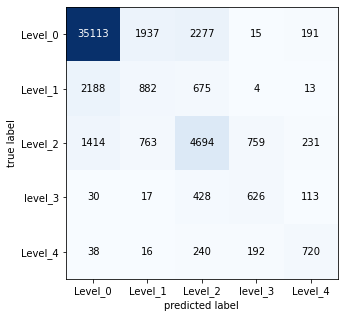

In [76]:
matrix = confusion_matrix (y_test, P4)
plot_confusion_matrix(matrix, figsize=(5,5))
plt.xticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)
plt.yticks(range(5), ['Level_0','Level_1','Level_2','level_3','Level_4'], fontsize=10)

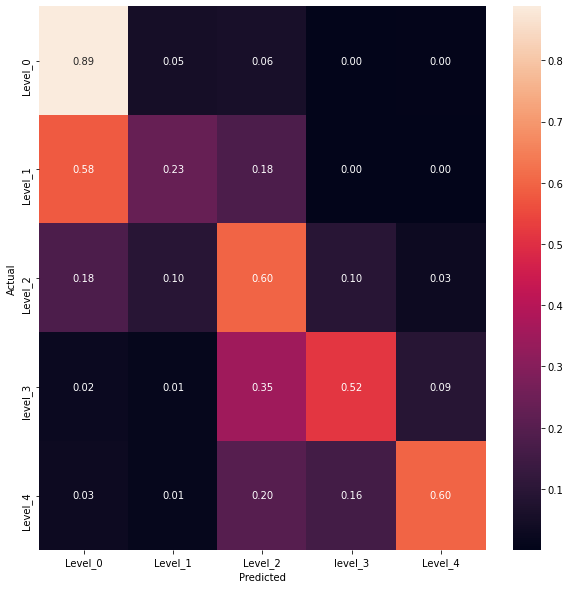

In [81]:
import seaborn as sns

target_names = ['Level_0','Level_1','Level_2','level_3','Level_4']
cm = confusion_matrix(y_test, P4)
# Normalise
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

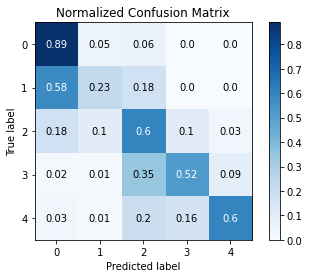

In [82]:
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(y_test, P4, normalize=True)